# Image classification with deep learning techniques

Code developed by Marcelo Ferrer and Aymen Merchaoui

In this notebook we will be using a convolutional neural network with torch library.

In [2]:
import torch

if torch.cuda.is_available():
    device_name = "cuda"
elif torch.backends.mps.is_available():
    device_name = "mps"
else:
    device_name = "cpu"
    
device = torch.device(device_name)
print(f"Code runs in {device}")

Code runs in cpu


### Step 1: Load the samples

In [3]:
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import csv
import matplotlib.pyplot as plt

class FashionDataset(Dataset):
    """User defined class to build a datset using Pytorch class Dataset."""
    
    def __init__(self, filename, transform = None):
        self.images, self.labels = self.load_mnist_dataset(filename)
        self.transform = transform
        
        
    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)


    def load_mnist_dataset(self, filename):
        f = open(filename, 'r')
        reader = csv.reader(f, delimiter=',')
        data = []
        images = []
        labels = []
        next(reader)
        for row in reader:
            labels.append(int(row[0]))
            images.append(np.array(row[1:]).astype(np.uint8).reshape(28,28))
        return np.array(images).astype(np.float32), np.array(labels)



In [4]:
train_valid_dataset = FashionDataset("res/fashion-mnist_train.csv", 
            transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = FashionDataset("res/fashion-mnist_test.csv", 
            transform=transforms.Compose([transforms.ToTensor()]))

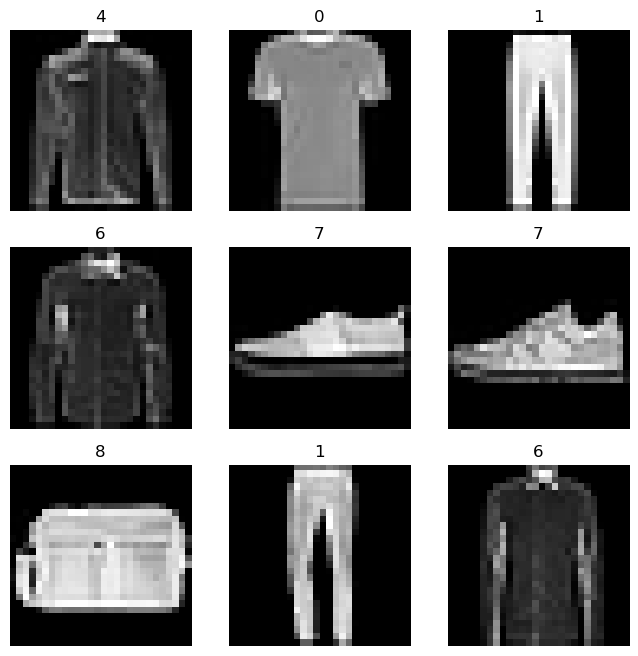

In [5]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_valid_dataset), size=(1,)).item()
    img, label = train_valid_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
### function to plot the loss and the accuracy of the model
def plot_loss_acc(train_loss,val_loss, train_acc,val_acc):
    fig, axs = plt.subplots(1,2)
    fig.suptitle(' Validation loss and accuracy')
    fig.set_figwidth(10)
    # plot the loss
    axs[0].plot(train_loss)
    axs[0].plot(val_loss)
    axs[0].set_title("model loss")
    axs[0].legend(["train_loss","val_loss"])
    axs[0].set_xlabel('Epochs')
    # plot the accuracy
    axs[1].plot(train_acc)
    axs[1].plot(val_acc)
    axs[1].set_title("model accuracy")
    axs[1].legend(["train_accuracy","val_accuracy"])
    axs[1].set_xlabel('Epochs')
    # show the plot
    plt.show()

In [7]:
VALID_RATIO = 0.2

num_train = int((1.0 - VALID_RATIO) * len(train_valid_dataset))
num_valid = len(train_valid_dataset) - num_train

print(f"Number of samples: training = {num_train} | validation = {num_valid}")

train_dataset, valid_dataset = torch.utils.data.dataset.random_split(train_valid_dataset, [num_train, num_valid])

Number of samples: training = 48000 | validation = 12000


### Step 2: Model architecture

In [8]:
import torch.nn as nn

class ToyCNN(nn.Module):

    def __init__(self):
        super(ToyCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels = 1, 
                out_channels = 32, 
                kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc1 = nn.Linear(in_features=32*12*12, out_features=600)
        ### 10 classes to classify
        self.fc2 = nn.Linear(in_features=600, out_features=10)


    def forward(self, x):
        out = self.conv1(x)
        # Flatten output of the previous conv layer to feed the next fc layer
        out = out.view(out.size(0), -1) 
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out

### Step 3: train the model

In [9]:
### Function to train the net one epoch
def train(model, loader, f_loss, optimizer, device):
    count = 0
    total_loss = 0.0
    correct = 0

    ### Indicates that the model is used for training
    model.train()

    ### Loop through the batches
    for i, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = f_loss(outputs, targets.long())

        # Accumulate the number of processed samples
        count += inputs.shape[0]

        # Accumulate the total loss
        total_loss += inputs.shape[0] * loss.item()

        # Compute total accuracy
        predictions = outputs.argmax(dim=1)
        correct += (predictions == targets).sum().item()

        # Backpropagate the error to change the model weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    ### Return the loss and the accuracy
    return total_loss/count, correct /count  

In [ ]:
from torch.optim import Adam

model = ToyCNN()
model.to(device)

batch_size = 64
f_loss = nn.CrossEntropyLoss()
optimizer=Adam(model.parameters(), lr=0.0001)

train_loader = DataLoader(train_dataset, batch_size=batch_size)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

loss, acc = train(model, train_loader, f_loss, optimizer, device)
torch.save(model, 'trained-model.pt')
print(f"Epoch 1 (training): Loss = {loss} | Accuracy = {acc}")

Epoch 1 (training): Loss = 2.9380513291060923 | Accuracy = 0.8053958333333333


In [ ]:
def test(model, loader, f_loss, device):
    count = 0
    total_loss = 0.0
    correct = 0

    ### Specify the model that one we are going to evaluate
    model.eval()

    ### Iterate for all the batches
    for i, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = f_loss(outputs, targets.long())

        # Accumulate the number of processed samples
        count += inputs.shape[0]

        # Accumulate the total loss
        total_loss += inputs.shape[0] * loss.item()

        # Compute total accuracy
        predictions = outputs.argmax(dim=1)
        correct += (predictions == targets).sum().item()

    return total_loss/count, correct /count  

In [ ]:
loss, acc = test(model, valid_loader, f_loss, device)
print(f"Epoch 1 (validation): Loss = {loss} | Accuracy = {acc}")

Epoch 1 (validation): Loss = 1.3743385504086811 | Accuracy = 0.8418333333333333


Function that trains the model for a given number of epochs. The function should output both validation loss and accuracy for each epoch.

In [ ]:
def train_model(model, train_dataset, valid_dataset, device,
                optimizer, 
                f_loss,
                batch_size=128, 
                num_epochs=20,
                output_filename='trained-model.pt',
                early_stopping = 5):
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

    best_loss = 0
    not_improve = 0
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    ### Write your code here
    for n_epoch in range(0,num_epochs):
        count = 0
        total_loss = 0.0
        correct = 0

        ### Indicates that the model is used for training
        model.train()

        ### Loop through the batches
        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = f_loss(outputs, targets.long())

            # Accumulate the number of processed samples
            count += inputs.shape[0]

            # Accumulate the total loss
            total_loss += inputs.shape[0] * loss.item()

            # Compute total accuracy
            predictions = outputs.argmax(dim=1)
            correct += (predictions == targets).sum().item()

            # Backpropagate the error to change the model weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_losses.append(total_loss/count)
        train_accs.append(correct /count)

        ### after each train, test the network with the validation set
        count = 0
        total_loss = 0.0
        correct = 0
        
        ### Indicates that the model is used for evaluation
        model.eval()

        ### Iterate for all the batches
        for i, (inputs, targets) in enumerate(valid_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = f_loss(outputs, targets.long())

            # Accumulate the number of processed samples
            count += inputs.shape[0]

            # Accumulate the total loss
            total_loss += inputs.shape[0] * loss.item()

            # Compute total accuracy
            predictions = outputs.argmax(dim=1)
            correct += (predictions == targets).sum().item()

        val_losses.append(total_loss/count)
        val_accs.append(correct /count) 

        print("Epoch", n_epoch + 1, "Train loss:", train_losses[n_epoch], "Train acc:", train_accs[n_epoch], 
              "Val loss:", val_losses[n_epoch], "Val acc:", val_accs[n_epoch])  

        ### If is the first epoch or the validation is lower that the previous one, save the model
        if (best_loss == 0 or val_losses[n_epoch] < best_loss ):
            best_loss = val_losses[n_epoch]
            torch.save(model, output_filename)
            print("Saving model. New loss:", best_loss)   
            not_improve = 0
        else:
            not_improve = not_improve + 1

        ### If the validations loss have not improve in X amount of epochs, stop the training
        if (not_improve >= early_stopping):
            print("Early stopping. Epochs without improve:", not_improve)  
            return train_losses, val_losses, train_accs, val_accs

    return train_losses, val_losses, train_accs, val_accs

In [ ]:
model = ToyCNN()
model.to(device)

batch_size = 128
f_loss = nn.CrossEntropyLoss()
optimizer=Adam(model.parameters(), lr=0.0001)
num_epochs=30

train_loss, val_loss, train_acc, val_acc = train_model(model, train_dataset, valid_dataset, device, optimizer, f_loss, batch_size,num_epochs)

Epoch 1 Train loss: 4.846759484132131 Train acc: 0.7839375 Val loss: 3.524475799560547 Val acc: 0.7614166666666666
Saving model. New loss: 3.524475799560547
Epoch 2 Train loss: 1.6925592448711395 Train acc: 0.844625 Val loss: 1.6216130650838216 Val acc: 0.8370833333333333
Saving model. New loss: 1.6216130650838216
Epoch 3 Train loss: 1.2083331914742788 Train acc: 0.8626666666666667 Val loss: 1.1372564029693604 Val acc: 0.8703333333333333
Saving model. New loss: 1.1372564029693604
Epoch 4 Train loss: 0.9274976479212443 Train acc: 0.8790416666666667 Val loss: 1.0999166650772094 Val acc: 0.8506666666666667
Saving model. New loss: 1.0999166650772094
Epoch 5 Train loss: 0.6215998499393464 Train acc: 0.8913958333333334 Val loss: 0.9337171748479207 Val acc: 0.8569166666666667
Saving model. New loss: 0.9337171748479207
Epoch 6 Train loss: 0.46404001251856486 Train acc: 0.9029375 Val loss: 0.766608811378479 Val acc: 0.8685833333333334
Saving model. New loss: 0.766608811378479
Epoch 7 Train loss

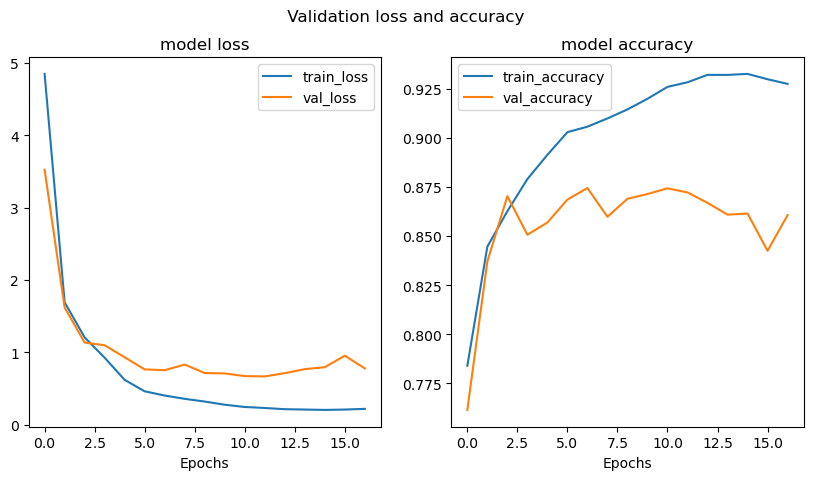

In [ ]:
plot_loss_acc(train_loss, val_loss, train_acc,val_acc)

In [ ]:
### Reload the model with the best parameters
best_model = torch.load('trained-model.pt', map_location=device)

test_loader = DataLoader(test_dataset)
loss, acc = test(best_model, test_loader, f_loss, device)
print("Test Accuracy:  Accuracy = ", acc)

Test Accuracy:  Accuracy =  0.8801


Another model architecture with two convolutional layers and three fully connected layers.

In [ ]:
class FashionMNISTCNN(nn.Module):

    def __init__(self):
        super(FashionMNISTCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels = 1, 
                out_channels = 32, 
                kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        #define a second conv layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels = 32, 
                out_channels = 32, 
                kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        #define three fully connected
        self.fc1 = nn.Linear(in_features=32*5*5, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)


    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        #PRINT THE SHAPE OF THE OUTPUT BECAUSE WE GOT SOME ERRORS: how to calculate the output shape of the second conv layer, which are the inPUT features of the next fc layer
        #print(out.shape)
        out = out.view(out.size(0), -1) 
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [ ]:
model = FashionMNISTCNN()
model.to(device)

batch_size = 128
f_loss = nn.CrossEntropyLoss()
optimizer=Adam(model.parameters(), lr=0.001)
num_epochs=30

train_loss, val_loss, test_acc, val_acc=train_model(model, train_dataset, valid_dataset, device, optimizer, f_loss, batch_size,num_epochs, 'trained-model-v2.pt')

Epoch 1 Train loss: 0.8116522269248962 Train acc: 0.7810625 Val loss: 0.5011245260238647 Val acc: 0.8118333333333333
Saving model. New loss: 0.5011245260238647
Epoch 2 Train loss: 0.44412242007255553 Train acc: 0.8383541666666666 Val loss: 0.4392597524325053 Val acc: 0.8423333333333334
Saving model. New loss: 0.4392597524325053
Epoch 3 Train loss: 0.4003964688380559 Train acc: 0.8569166666666667 Val loss: 0.42292560036977134 Val acc: 0.84325
Saving model. New loss: 0.42292560036977134
Epoch 4 Train loss: 0.3724971420764923 Train acc: 0.8659791666666666 Val loss: 0.4050692481994629 Val acc: 0.8505
Saving model. New loss: 0.4050692481994629
Epoch 5 Train loss: 0.35533762272198993 Train acc: 0.8717916666666666 Val loss: 0.3918629320462545 Val acc: 0.8556666666666667
Saving model. New loss: 0.3918629320462545
Epoch 6 Train loss: 0.3417896163860957 Train acc: 0.8766666666666667 Val loss: 0.38657428582509357 Val acc: 0.861
Saving model. New loss: 0.38657428582509357
Epoch 7 Train loss: 0.330

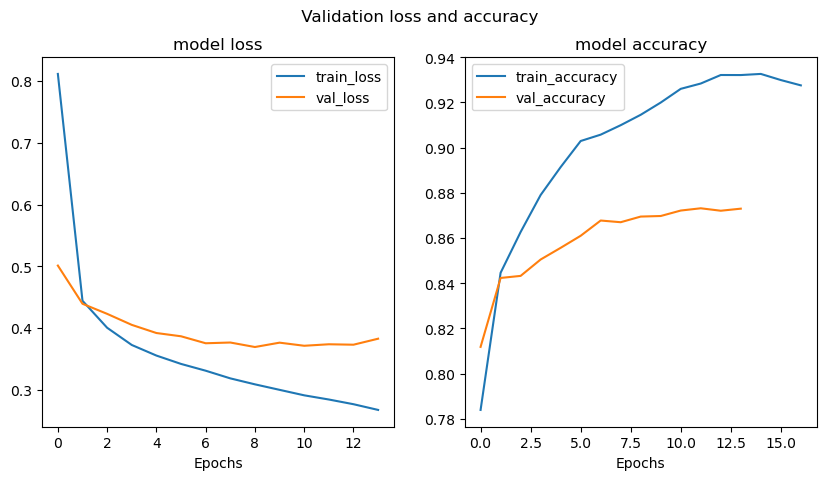

In [ ]:
plot_loss_acc(train_loss, val_loss,train_acc, val_acc)

In [ ]:
# Compute accuracy in the test dataset
### Reload the model with the best parameters
best_model2 = torch.load('trained-model-v2.pt', map_location=device)
best_model2.to(device)

test_loader = DataLoader(test_dataset)
loss , acc = test(best_model2, test_loader, f_loss, device)
print("Test Accuracy:  Accuracy = ",acc)

Test Accuracy:  Accuracy =  0.8759


Now we repeat the experiment, but this time we keep the optimizer in a learning rate of 0.0001.

In [ ]:
model = FashionMNISTCNN()
model.to(device)

batch_size = 128
f_loss = nn.CrossEntropyLoss()
optimizer=Adam(model.parameters(), lr=0.0001)
num_epochs=30

train_loss, val_loss, test_acc, val_acc=train_model(model, train_dataset, valid_dataset, device, optimizer, f_loss, batch_size,num_epochs, 'trained-model-v2lr.pt')

Epoch 1 Train loss: 0.6234899685382843 Train acc: 0.7855 Val loss: 0.4464001208941142 Val acc: 0.8378333333333333
Saving model. New loss: 0.4464001208941142
Epoch 2 Train loss: 0.3895006205240885 Train acc: 0.8592083333333334 Val loss: 0.390105286916097 Val acc: 0.86025
Saving model. New loss: 0.390105286916097
Epoch 3 Train loss: 0.34547909677028654 Train acc: 0.8752083333333334 Val loss: 0.36862441778182986 Val acc: 0.8671666666666666
Saving model. New loss: 0.36862441778182986
Epoch 4 Train loss: 0.3194243945678075 Train acc: 0.8847916666666666 Val loss: 0.35760081179936726 Val acc: 0.8705
Saving model. New loss: 0.35760081179936726
Epoch 5 Train loss: 0.301267241080602 Train acc: 0.890375 Val loss: 0.35233219448725384 Val acc: 0.87225
Saving model. New loss: 0.35233219448725384
Epoch 6 Train loss: 0.28707685216267903 Train acc: 0.894625 Val loss: 0.3529554929733276 Val acc: 0.8726666666666667
Epoch 7 Train loss: 0.2759339955250422 Train acc: 0.8994375 Val loss: 0.3518190310796102 V

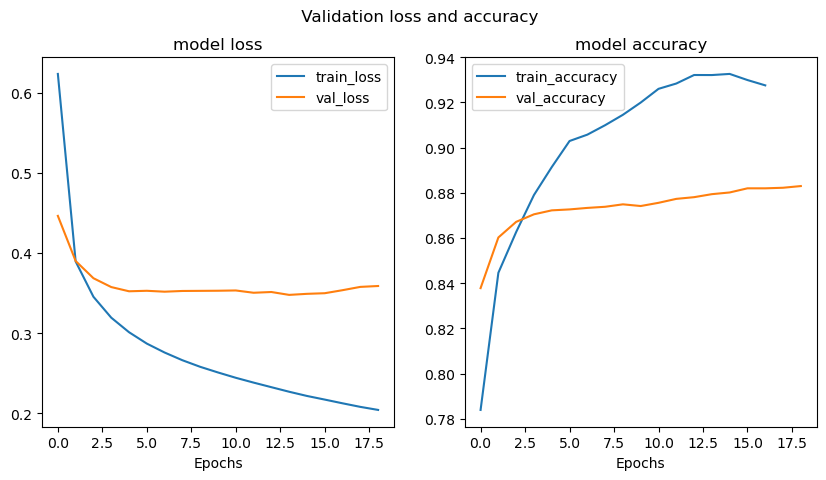

In [ ]:
plot_loss_acc(train_loss, val_loss,train_acc, val_acc)

In [ ]:
# Compute accuracy in the test dataset
### Reload the model with the best parameters
best_model2 = torch.load('trained-model-v2lr.pt', map_location=device)
best_model2.to(device)

test_loader = DataLoader(test_dataset)
loss , acc = test(best_model2, test_loader, f_loss, device)
print("Test Accuracy:  Accuracy = ",acc)

Test Accuracy:  Accuracy =  0.8869


Include batch normalization

In [ ]:
class FashionMNISTv2CNN(nn.Module):

    def __init__(self):
        super(FashionMNISTv2CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels = 1, 
                out_channels = 32, 
                kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        #define a second conv layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels = 32, 
                out_channels = 64, 
                kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Linear(in_features=64*5*5, out_features=256)
        self.drop1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.drop2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        #PRINT THE SHAPE OF THE OUTPUT BECAUSE WE GOT SOME ERRORS: how to calculate the output shape of the second conv layer, which are the inPUT features of the next fc layer
        #print(out.shape)
        out = out.view(out.size(0), -1) 
        out = self.fc1(out)
        out = self.drop1(out)
        out = self.fc2(out)
        out = self.drop2(out)
        out = self.fc3(out)
        
        return out


In [ ]:
model = FashionMNISTv2CNN()
model.to(device)

batch_size = 128
f_loss = nn.CrossEntropyLoss()
### we mantain the learning rate in 0.0001 as it give us better results before
optimizer=Adam(model.parameters(), lr=0.0001)
num_epochs=30

train_loss, val_loss, train_acc, val_acc= train_model(model, train_dataset, valid_dataset, device, optimizer, f_loss, batch_size,num_epochs, 'trained-model-v3.pt')

Epoch 1 Train loss: 0.7619350544611613 Train acc: 0.7367291666666667 Val loss: 0.46899776951471966 Val acc: 0.838
Saving model. New loss: 0.46899776951471966
Epoch 2 Train loss: 0.4678334693908691 Train acc: 0.8344166666666667 Val loss: 0.3827630508740743 Val acc: 0.8678333333333333
Saving model. New loss: 0.3827630508740743
Epoch 3 Train loss: 0.4024935410022736 Train acc: 0.8584375 Val loss: 0.3559917697906494 Val acc: 0.8740833333333333
Saving model. New loss: 0.3559917697906494
Epoch 4 Train loss: 0.3664675251245499 Train acc: 0.8703958333333334 Val loss: 0.3375817726453145 Val acc: 0.8825833333333334
Saving model. New loss: 0.3375817726453145
Epoch 5 Train loss: 0.3436575669447581 Train acc: 0.8787083333333333 Val loss: 0.32503676748275756 Val acc: 0.8858333333333334
Saving model. New loss: 0.32503676748275756
Epoch 6 Train loss: 0.3251628802617391 Train acc: 0.8863333333333333 Val loss: 0.3152931406497955 Val acc: 0.89025
Saving model. New loss: 0.3152931406497955
Epoch 7 Train l

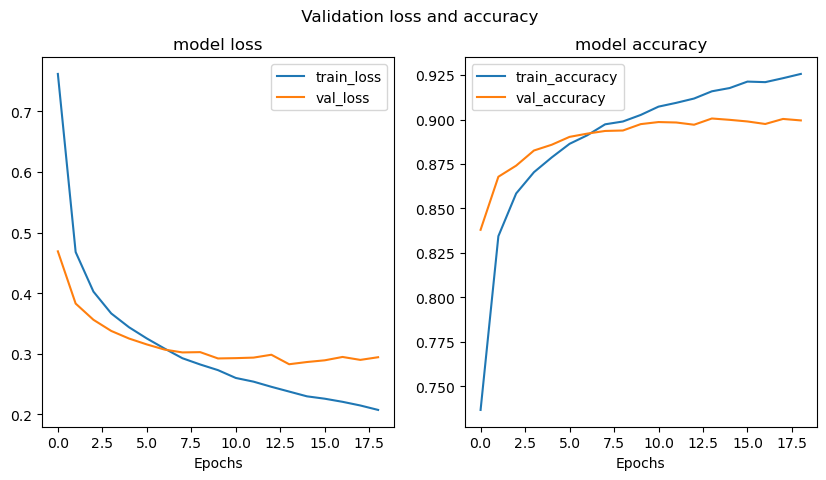

In [ ]:
plot_loss_acc(train_loss, val_loss,train_acc, val_acc)

In [ ]:
### Reload the model with the best parameters
best_model3 = torch.load('trained-model-v3.pt', map_location=device)
best_model3.to(device)

test_loader = DataLoader(test_dataset)
loss , acc = test(best_model3, test_loader, f_loss, device)
print("Test Accuracy:  Accuracy = ",acc)

Test Accuracy:  Accuracy =  0.9041


In [ ]:
model = FashionMNISTv2CNN()
model.to(device)

batch_size = 128
f_loss = nn.CrossEntropyLoss()
### we try the learning rate in 0.0001 as it give us better results before
optimizer=Adam(model.parameters(), lr=0.0001)
### more epochs as regularization techniques give us more room to improve
num_epochs=30

train_loss, val_loss, train_acc, val_acc= train_model(model, train_dataset, valid_dataset, device, optimizer, f_loss, batch_size,num_epochs, 'trained-model-v3lr.pt')

Epoch 1 Train loss: 0.774980922460556 Train acc: 0.729125 Val loss: 0.4692860983212789 Val acc: 0.83425
Saving model. New loss: 0.4692860983212789
Epoch 2 Train loss: 0.4688358941078186 Train acc: 0.8346666666666667 Val loss: 0.39065591128667193 Val acc: 0.8645
Saving model. New loss: 0.39065591128667193
Epoch 3 Train loss: 0.40102377299467723 Train acc: 0.8589791666666666 Val loss: 0.35630539878209433 Val acc: 0.8760833333333333
Saving model. New loss: 0.35630539878209433
Epoch 4 Train loss: 0.3664703003168106 Train acc: 0.8713333333333333 Val loss: 0.34100861167907714 Val acc: 0.8798333333333334
Saving model. New loss: 0.34100861167907714
Epoch 5 Train loss: 0.3413961717685064 Train acc: 0.8795625 Val loss: 0.33100560967127485 Val acc: 0.8833333333333333
Saving model. New loss: 0.33100560967127485
Epoch 6 Train loss: 0.32105733195940656 Train acc: 0.8871875 Val loss: 0.3225072600046794 Val acc: 0.8865833333333333
Saving model. New loss: 0.3225072600046794
Epoch 7 Train loss: 0.307644

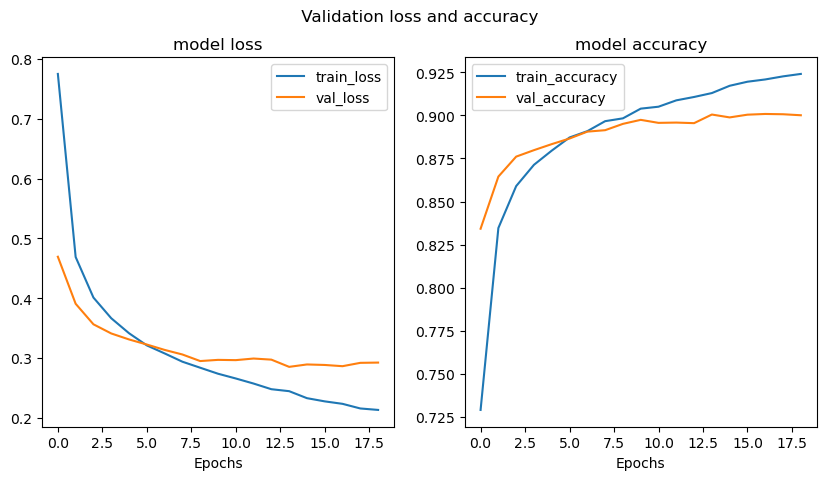

In [ ]:
plot_loss_acc(train_loss, val_loss,train_acc, val_acc)

In [ ]:
### Reload the model with the best parameters
best_model3 = torch.load('trained-model-v3lr.pt', map_location=device)
best_model3.to(device)

test_loader = DataLoader(test_dataset)
loss , acc = test(best_model3, test_loader, f_loss, device)
print("Test Accuracy:  Accuracy = ",acc)

Test Accuracy:  Accuracy =  0.9055
